In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

In [7]:
# Càrrega del dataset.
data = pd.read_csv("train_titanic.csv")

# 2. Integració i selecció de les dades d’interès a analitzar

In [8]:
# Variables importants:
# SURVIVED
# PCLASS
# SEX
# AGE
# EMBARKED
# FARE
data_vars = data[["Pclass","Sex","Age","Embarked", "Fare","Survived"]]

# 3. Neteja de les dades

## 3.1. Les dades contenen zeros o elements buits? Com gestionaries aquests casos?

In [9]:
# Recompte de valors nuls.
for var in data_vars:
    print("La variable",var,"conté",data_vars[var].isna().sum(),"valors nuls")

La variable Pclass conté 0 valors nuls
La variable Sex conté 0 valors nuls
La variable Age conté 177 valors nuls
La variable Embarked conté 2 valors nuls
La variable Fare conté 0 valors nuls
La variable Survived conté 0 valors nuls


In [10]:
# Reomplim els NA a partir de la mediana de les edats per Sexe.
data_vars['Age'].fillna(data_vars.groupby('Sex')['Age'].transform("median"), inplace=True)
# Elimino les dues observacions amb NA de "Embarked"
data_vars = data_vars.dropna()

C:\Users\VilaGras\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## 3.2. Conversió de valors (punt afegit)

In [11]:
#Conversió "male" - "famale" en enters:
data_clean = data_vars.replace("female",2)
data_clean = data_clean.replace("male", 1)

# Conversió dels tres valors d'embarked:
data_clean["Embarked"] = data_clean["Embarked"].replace("C", 1)
data_clean["Embarked"] = data_clean["Embarked"].replace("Q", 2)
data_clean["Embarked"] = data_clean["Embarked"].replace("S", 3)

# Conversió de "Age" a enters:
data_clean["Age"] = data_clean["Age"].round().astype(int)

## 3.3. Identificació i tractament de valors extrems

In [12]:
# Valors extrems
print(data_clean.describe())

           Pclass         Sex         Age    Embarked        Fare    Survived
count  889.000000  889.000000  889.000000  889.000000  889.000000  889.000000
mean     2.311586    1.350956   29.390326    2.535433   32.096681    0.382452
std      0.834700    0.477538   12.982384    0.792088   49.697504    0.486260
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000
25%      2.000000    1.000000   22.000000    2.000000    7.895800    0.000000
50%      3.000000    1.000000   29.000000    3.000000   14.454200    0.000000
75%      3.000000    2.000000   35.000000    3.000000   31.000000    1.000000
max      3.000000    2.000000   80.000000    3.000000  512.329200    1.000000


## 3.4. Emmagatzemar dataframe net (punt afegit)

In [13]:
# Guardo el dataset net:
data_clean.to_csv("data_clean.csv")

# 4. ANÀLISI DE LES DADES

In [14]:
# Càrrega del dataset.
col = ["Pclass", "Sex", "Age", "Embarked", "Fare", "Survived"]
data = pd.read_csv("data_clean.csv", usecols = col )

## 4.1. Selecció dels grups de dades que es volen analitzar/comparar

In [15]:
# Agrupacions per Sexe i Classe
female = data.loc[data['Sex'] == 2]
male = data.loc[data['Sex'] == 1]
upper = data.loc[data['Pclass'] == 1]
middle = data.loc[data['Pclass'] == 2]
lower = data.loc[data['Pclass'] == 3]

## 4.2. Comprovació de la normalitat i homogeneïtat de la variància

In [16]:
# Revisem normalitat (Prova de normalitat Anderson-Darling).
# Si p-value > 0.5, implica distribució normal.
for var in data:
    res = scipy.stats.anderson(data[var])
    print("El p-value de la variable",var,"és",res[1][2], "i el estadístic és",res[0])

El p-value de la variable Pclass és 0.783 i el estadístic és 110.07359556722486
El p-value de la variable Sex és 0.783 i el estadístic és 178.57044801344568
El p-value de la variable Age és 0.783 i el estadístic és 15.177390367849057
El p-value de la variable Embarked és 0.783 i el estadístic és 182.60119840206448
El p-value de la variable Fare és 0.783 i el estadístic és 122.80816188550375
El p-value de la variable Survived és 0.783 i el estadístic és 171.3628439667541


In [17]:
# Test de Levene per analitzar la homogeneïtat de la variància.
hom_sex = scipy.stats.levene(data["Survived"][data["Sex"]==1],
                  data["Survived"][data["Sex"]==2])

hom_class = scipy.stats.levene(data["Survived"][data["Pclass"]==1],
                  data["Survived"][data["Pclass"]==2],
                  data["Survived"][data["Pclass"]==3])

hom_emb = scipy.stats.levene(data["Survived"][data["Embarked"]==1],
                  data["Survived"][data["Embarked"]==2],
                  data["Survived"][data["Embarked"]==3])

print(hom_sex)
print(hom_class)
print(hom_emb)
# p-value < 0.05 --> rebuig hipòtesi nul·la --> diferència entre variàncies.

LeveneResult(statistic=6.052073198971666, pvalue=0.014079700102452174)
LeveneResult(statistic=18.743249946154936, pvalue=1.0651350809216878e-08)
LeveneResult(statistic=3.6101502536808128, pvalue=0.027446419795460055)


# 4.3. Aplicació de proves estadístiques per comparar els grups de dades. En funció de les dades i de l’objectiu de l’estudi, aplicar proves de contrast d’hipòtesis, correlacions, regressions, etc.

In [18]:
# Correlació entre variables.
corr = data.corr()
print(corr)

            Pclass       Sex       Age  Embarked      Fare  Survived
Pclass    1.000000 -0.127741 -0.335053  0.164681 -0.548193 -0.335549
Sex      -0.127741  1.000000 -0.100592 -0.110320  0.179958  0.541585
Age      -0.335053 -0.100592  1.000000 -0.020347  0.091372 -0.077904
Embarked  0.164681 -0.110320 -0.020347  1.000000 -0.226311 -0.169718
Fare     -0.548193  0.179958  0.091372 -0.226311  1.000000  0.255290
Survived -0.335549  0.541585 -0.077904 -0.169718  0.255290  1.000000


In [19]:
# Regressió lineal.
# Creo 3 models:
#   1 - Amb totes les variables triades.
#   2 - Amb les variables més importants segons l'estudi de correlació: Sex, Fare i Age
#   3-  Amb la variable amb màxima correlació: Sex

def reg_lin(data_X, data_Y):
    data_X_train = data_X[:-200]
    data_Y_train = data_Y[:-200]

    data_X_test = data_X[-200:]
    data_Y_test = data_Y[-200:]
    
    regr = linear_model.LinearRegression()
    regr.fit(data_X_train, data_Y_train)

    survived_pred = regr.predict(data_X_test)

    # Càlculs:
    MSE = mean_squared_error(data_Y_test, survived_pred)
    acc = accuracy_score(data_Y_test, survived_pred.round())
    cm = confusion_matrix(data_Y_test, survived_pred.round())
    return(MSE, acc, cm, regr)

data_X_m1 = data[["Pclass", "Sex", "Age", "Embarked", "Fare"]]
data_X_m2 = data[["Sex", "Age", "Fare"]]
data_X_m3 = data[["Sex"]]
data_Y = data[["Survived"]]


MSE1, acc1, cm1, regr1 = reg_lin(data_X_m1,data_Y)
MSE2, acc2, cm2, regr2 = reg_lin(data_X_m2,data_Y)
MSE3, acc3, cm3, regr3 = reg_lin(data_X_m3,data_Y)

# 5. Representació dels resultats a partir de taules i gràfiques.

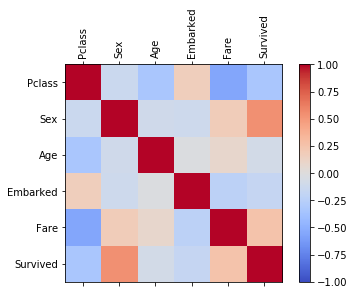

In [20]:
# Correlació de les variables:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

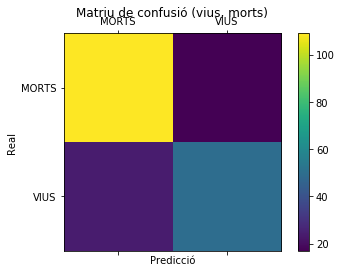

La taula amb els valors és la següent:
 [[109  17]
 [ 24  50]]


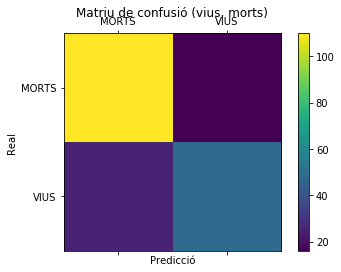

La taula amb els valors és la següent:
 [[110  16]
 [ 25  49]]


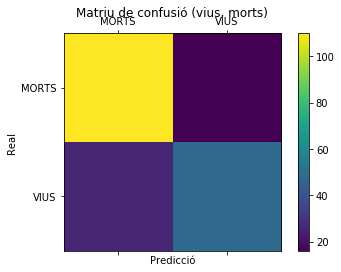

La taula amb els valors és la següent:
 [[110  16]
 [ 26  48]]


In [21]:
# Matrius de Confusió dels models:
def representa_mtx(cm):
    labels = ['MORTS', 'VIUS']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title("Matriu de confusió (vius, morts)")
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicció')
    plt.ylabel('Real')
    plt.show()
    print("La taula amb els valors és la següent:\n",cm)

representa_mtx(cm1)
representa_mtx(cm2)
representa_mtx(cm3)

In [22]:
# Valors de MES i precissió:
print("MODEL 1:\n    Error quadràtic mig (MSE) =",MSE1,"\n    Precissió =",acc1)
print("MODEL 2:\n    Error quadràtic mig (MSE) =",MSE2,"\n    Precissió =",acc2)
print("MODEL 3:\n    Error quadràtic mig (MSE) =",MSE3,"\n    Precissió =",acc3)

MODEL 1:
    Error quadràtic mig (MSE) = 0.1367640225295661 
    Precissió = 0.795
MODEL 2:
    Error quadràtic mig (MSE) = 0.1540867313916442 
    Precissió = 0.795
MODEL 3:
    Error quadràtic mig (MSE) = 0.1651998745924483 
    Precissió = 0.79


## 6. Resolució del problema. A partir dels resultats obtinguts, quines són les conclusions? Els resultats permeten resoldre el problema?

In [23]:
# Càrrega del dataset.
data_test= pd.read_csv("test_titanic.csv")

data_test_vars = data_test[["Sex","Age","Fare"]]

print ("El dataset conté:",len(data_test_vars),"registres")

for var in data_test_vars:
    print("La variable",var,"conté",data_test_vars[var].isna().sum(),"valors nuls")

El dataset conté: 418 registres
La variable Sex conté 0 valors nuls
La variable Age conté 86 valors nuls
La variable Fare conté 1 valors nuls


In [32]:
#### NETEJA
# Reomplim els NA a partir de la mediana de les edats per Sexe.
data_test_vars['Age'].fillna(data_test_vars.groupby('Sex')['Age'].transform("median"), inplace=True)
data_test_vars['Fare'].fillna(data_test_vars.groupby('Sex')['Fare'].transform("median"), inplace=True)

#### CONVERSIÓ
#Conversió "male" - "famale" en enters:
data_test_clean = data_test_vars.replace("female",2)
data_test_clean = data_test_clean.replace("male", 1)
# Conversió de "Age" a enters:
data_test_clean["Age"] = data_test_clean["Age"].round().astype(int)

C:\Users\VilaGras\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [31]:
pred = regr2.predict(data_test_clean)
resultat = data_test.assign(Survived_PRED = pred.round())

print(resultat[0:10])

# Recompte de morts i supervivents.
sumari = resultat["Survived_PRED"].value_counts()
print("En total moren", sumari[0], "passatgers i sobreviuen", sumari[1],"passatgers")

# Emmagatzemo
resultat.to_csv("resultat.csv")

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5          897       3                    Svensson, Mr. Johan Cervin    male   
6          898       3                          Connolly, Miss. Kate  female   
7          899       2                  Caldwell, Mr. Albert Francis    male   
8          900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9          901       3                       Davies, Mr. John Samuel    male   

    Age  SibSp  Parch     Ticket     Fare Cabin Embarked  Survived_PRED  
0  34.5      0      0     330911   7.8292   N